(74612, 20)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74612 entries, 0 to 74611
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Accident_Date            74612 non-null  datetime64[ns]
 1   Accident_Time            74612 non-null  object        
 2   Location_Type            74612 non-null  object        
 3   Initial_Impact_Type      74607 non-null  object        
 4   Road_Surface_Condition   74611 non-null  object        
 5   Environment_Condition    74610 non-null  object        
 6   Light                    74612 non-null  object        
 7   Num_of_Vehicle           74612 non-null  int64         
 8   Num_Of_Pedestrians       74612 non-null  int64         
 9   Num_of_Bicycles          1347 non-null   float64       
 10  Num_of_Motorcycles       637 non-null    float64       
 11  Max_Injury               13469 non-null  object        
 12  Num_of_Injuries     

y
03 - P.D. only           61195
02 - Non-fatal injury    13276
01 - Fatal injury          141
Name: count, dtype: int64

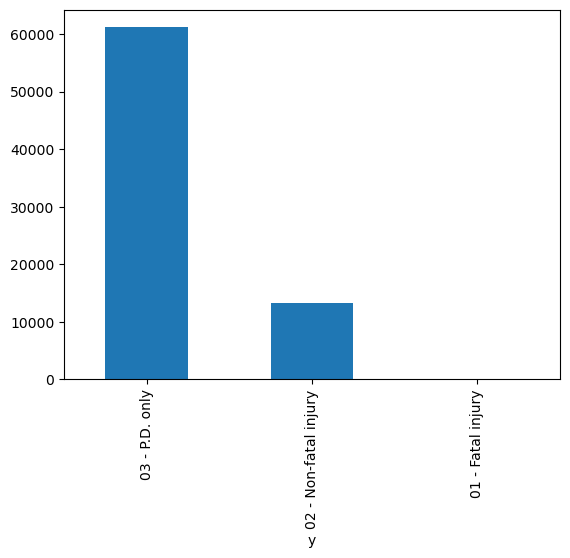

In [44]:
import pandas as pd

#Read the dataset
df = pd.read_csv('./Traffic_Collision_Data.csv')

df['y'] = df['Classification_Of_Accident']

#Remove columns that won't be useful
df.drop(['ID', 'Geo_ID', 'X', 'Y', 'Accident_Year', 'Location', 'Traffic_Control', 'X_Coordinate', 'Y_Coordinate', 'ObjectId', 'Classification_Of_Accident'], axis = 1, inplace = True)

#Convert column to right variable type
df['Accident_Date'] = pd.to_datetime(df['Accident_Date'])

print(df.shape)
df.info()
df.loc[:, ['Accident_Date']]
df.loc[:, ['y']]
df['y'].value_counts().plot(kind='bar')
df['y'].value_counts(normalize=False)

# Feature Engineering for Accident_Time Column

Random forest can only process numerical values, and Accident_Time column is time type. Therefore, random forest is not able to understand and correctly process this column. That being said, we need a way to successfully convert Accident_Time into a numerical value, which conserves the cyclical nature of time (meaning, 23:00 is closer to 1:00 than 11:00 is to 14:00).

To achieve this, the first thing we need to convert time hh:mm into only mm. For example, time 8:45 would be converted into 525 minutes (8 hours * 60 minutes + 45 minutes). The general formula is as follows, where $t$ represents hh:mm, and $t_{hh}$ represents only the hh part.

$$minutes(t) = (t_{hh} * 60) + t_{mm} $$

With that in mind, I found a well known approach for this: using sine and cosine to transform our time into numerical values that can keep their cyclical properties. 

It means, we will create two new columns from our single Accident_Time column, by using the following formulas:

$$sin\_time(t) = \sin(\frac{2\pi * minutes(t)}{1440})$$

$$cos\_time(t) = \cos(\frac{2\pi * minutes(t)}{1440})$$



In [45]:
import numpy as np
#Feature engineering for Accident_Time
#Before starting, we need to remove all Unkown values from the dataset
df = df.loc[df['Accident_Time'] != 'Unknown']

#First step: convert time hh:mm to only mm
times = pd.to_datetime(df['Accident_Time'], format = '%H:%M', errors = 'coerce')
hours = times.dt.hour
minutes = times.dt.minute
time_minutes = (hours*60) + minutes

df['time_minutes'] = time_minutes

#Second step: create columns for sin_time and cosine_time
calculated_time = (2 * np.pi * df['time_minutes']) / 1440
df['sin_time'] = np.sin(calculated_time)
df['cos_time'] = np.cos(calculated_time)

#Third step: remove original Accident_Time column since it won't be of any use
df.drop(['Accident_Time'], axis = 1, inplace = True)

df.loc[:, ['sin_time', 'cos_time']]

,sin_time,cos_time
0,0.374607,0.927184
1,0.754710,0.656059
2,0.944089,-0.329691
3,0.713250,-0.700909
4,0.082808,-0.996566
...,...,...
74607,0.034899,-0.999391
74608,-0.043619,-0.999048
74609,-0.675590,-0.737277
74610,-0.700909,-0.713250


In [46]:
#Feature engineer for Accident_Date, pretty similar to the approach used for Accident_Time, but converting dates into number of days. 
#First step: convert date into number of the day of the year.
df['Accident_Day'] = df['Accident_Date'].dt.dayofyear

#Second step: create columns for Sin_Accident_Day and Cos_Accident_Day
calculated_day = (2 * np.pi * df['Accident_Day']) / 366
df['Sin_Accident_Day'] = np.sin(calculated_day)
df['Cos_Accident_Day'] = np.cos(calculated_day)

#Third step: remove original Accident_Date column since it won't be of any use
df.drop(['Accident_Date'], axis = 1, inplace = True)

df.loc[:, ['Sin_Accident_Day', 'Cos_Accident_Day']]

,Sin_Accident_Day,Cos_Accident_Day
0,0.017166,0.999853
1,0.017166,0.999853
2,0.017166,0.999853
3,0.017166,0.999853
4,0.017166,0.999853
...,...,...
74607,0.477536,-0.878612
74608,0.477536,-0.878612
74609,0.477536,-0.878612
74610,0.477536,-0.878612


In [47]:
#Feature engineeer for location type, consists on encoding, midblock is now 0 and intersection is now 1
df['Location_Type'] = df['Location_Type'].map({'Midblock': 0, 'Intersection': 1})
df['Location_Type'].unique()
df.loc[:, 'Location_Type']

0        0
1        0
2        1
3        1
4        1
        ..
74607    0
74608    0
74609    0
74610    0
74611    0
Name: Location_Type, Length: 71855, dtype: int64

In [48]:
from sklearn.preprocessing import LabelEncoder

#Feature engineer for Initial Impact Type, this time I'll use scikit learn to encode.
#First step: remove any nan values from dataset
df.dropna(subset = ['Initial_Impact_Type'], inplace = True)

#Second step: prepare encoder and encode
encoder = LabelEncoder()
df['Initial_Impact_Type'] = encoder.fit_transform(df['Initial_Impact_Type'])

df.loc[:, 'Initial_Impact_Type']


0        6
1        3
2        6
3        2
4        7
        ..
74607    2
74608    6
74609    2
74610    2
74611    3
Name: Initial_Impact_Type, Length: 71851, dtype: int64

In [49]:
#Feature engineer for Road surface condition, this time I'll use scikit learn to encode.
#First step: remove any nan values from dataset
df.dropna(subset = ['Road_Surface_Condition'], inplace = True)

#Second step: prepare encoder and encode
encoder = LabelEncoder()
df['Road_Surface_Condition'] = encoder.fit_transform(df['Road_Surface_Condition'])
df.loc[:, 'Initial_Impact_Type']

0        6
1        3
2        6
3        2
4        7
        ..
74607    2
74608    6
74609    2
74610    2
74611    3
Name: Initial_Impact_Type, Length: 71851, dtype: int64

In [50]:
#Feature engineer for Environment Condition, this time I'll use scikit learn to encode.
#First step: remove any nan values from dataset
df.dropna(subset = ['Environment_Condition'], inplace = True)

#Second step: prepare encoder and encode
encoder = LabelEncoder()
df['Environment_Condition'] = encoder.fit_transform(df['Environment_Condition'])

df.loc[:, 'Environment_Condition']

0        2
1        3
2        5
3        3
4        1
        ..
74607    1
74608    1
74609    1
74610    1
74611    1
Name: Environment_Condition, Length: 71849, dtype: int64

In [76]:
df = df[df['Light'] != '00 - Unknown']
df.loc[df['Light'] == '00 - Unknown', 'Light'].count()

encoder = LabelEncoder()
df['Light'] = encoder.fit_transform(df['Light'])

print(df['Light'].unique())
print(df.loc[:, 'Light'])

df = df[df['Max_Injury'] != 'NaN']
print(df.loc[df['Max_Injury'] == 'NaN', 'Light'].count())

encoder = LabelEncoder()
df['Max_Injury'] = encoder.fit_transform(df['Max_Injury'])
df['y'] = encoder.fit_transform(df['y'])

print(df['Max_Injury'].unique())
print(df.loc[:, 'Max_Injury'])

df[["Num_of_Bicycles", "Num_of_Motorcycles", "Num_of_Injuries", "Num_of_Minor_Injuries", "Num_of_Minimal_Injuries", "Num_of_Major_Injuries", "Num_of_Fatal_Injuries"]] = df[["Num_of_Bicycles", "Num_of_Motorcycles", "Num_of_Injuries", "Num_of_Minor_Injuries", "Num_of_Minimal_Injuries", "Num_of_Major_Injuries", "Num_of_Fatal_Injuries"]].fillna(0)

[3 1 0 2 4]
0        3
1        3
2        1
3        0
4        0
        ..
74607    0
74608    0
74609    0
74610    0
74611    0
Name: Light, Length: 71841, dtype: int64
0
[5 2 1 3 4 0]
0        5
1        5
2        5
3        5
4        5
        ..
74607    5
74608    5
74609    5
74610    5
74611    5
Name: Max_Injury, Length: 71841, dtype: int64


In [79]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.tree import export_graphviz
from IPython.display import Image
#import graphviz

X = df.drop(['y', 'Num_of_Minimal_Injuries', 'Num_of_Major_Injuries', 'Num_of_Fatal_Injuries', 'Max_Injury'], axis=1)
y = df[['y', 'Num_of_Minimal_Injuries', 'Num_of_Major_Injuries', 'Num_of_Fatal_Injuries', 'Max_Injury']]

for col in y.columns:
    missing_count = y[col].isna().sum()
    # check if column dtype is object or string
    if y[col].dtype == 'object':
        print(f"🔍 Column '{col}' contains strings. Sample values:")
        print(y[col].unique()[:5])
    elif missing_count > 0:
        print(f"⚠️ Column '{col}' has {missing_count} missing values.")
        print(f"   Dtype: {y[col].dtype}")
        print("-" * 60)

comb_counts = y.value_counts()
valid_combinations = comb_counts[comb_counts > 1].index

mask = y.apply(tuple, axis = 1 ).isin(valid_combinations)
X = X[mask]
y = [mask]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

ValueError: Found input variables with inconsistent numbers of samples: [71827, 1]